<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/concate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import HashingVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, GaussianNoise, Input
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2
from sklearn.model_selection import train_test_split

0         -8.32
1        -20.73
2        -22.23
3        -57.71
4        -59.21
         ...   
1499    1364.32
1500    1358.71
1501    1315.00
1502    1313.60
1503    1301.08
Name: Description, Length: 1504, dtype: float64


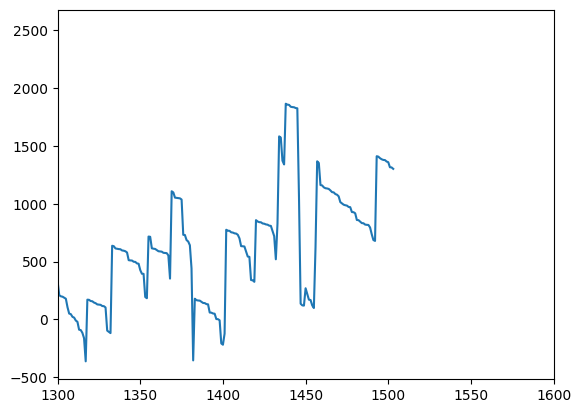

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Chase2387_Activity_20230531 (1).CSV')
price = df.pop('Description')
sum = np.cumsum(price)
sum = sum.reset_index(drop=True)
words = df.pop('Posting Date')
date = df.pop('Details')
plt.xlim(1300,1600)
plt.plot(sum)
print(sum)

In [4]:
def remove_non_letters(input_array):
    return [''.join(filter(str.isalpha, s)) for s in input_array]

result = remove_non_letters(words)
result = np.array(result)


In [5]:

# Create a HashingVectorizer instance
vectorizer = HashingVectorizer(n_features=10)

# Fit and transform the array of words
encoded_words = vectorizer.fit_transform(result).toarray()

encoded_words = np.array(encoded_words)

worddf = pd.DataFrame(encoded_words)

print(worddf)

        0    1    2    3    4    5    6    7    8    9
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
1     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2     0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.0  0.0  0.0  0.0 -1.0  0.0  0.0  0.0  0.0
4     0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
1499  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 -1.0
1500  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 -1.0
1501  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
1502  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
1503  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 -1.0

[1504 rows x 10 columns]


In [6]:
Date = pd.DataFrame()
# Convert the date column to a datetime object
date = pd.to_datetime(date)

# Extract the month, day, and day of the week as a number
Date['month'] = date.dt.month
Date['day'] = date.dt.day
Date['day_of_week'] = date.dt.day_of_week

Date = Date.reset_index(drop=True)

print(Date)

      month  day  day_of_week
0         5   31            2
1         5   31            2
2         5   31            2
3         5   30            1
4         5   30            1
...     ...  ...          ...
1499     12   14            1
1500     12   14            1
1501     12   13            0
1502     12   13            0
1503     12   13            0

[1504 rows x 3 columns]


In [7]:
pricedf = pd.DataFrame(price)
pricedf = pricedf.rename(columns={'Description': 'Price'})
sumdf = pd.DataFrame(sum)
sumdf = sumdf.rename(columns={'Description': 'Sum'})
lagged = sumdf.rename(columns={'Sum': 'Target'})
sumdf = sumdf.reset_index(drop=True)
lagged = lagged.reset_index(drop=True)
pricedf = pricedf.reset_index(drop=True)

input = pd.concat([Date,pricedf,sumdf,lagged,worddf],axis=1)

input['Target'] = input['Target'].shift(periods=30)

input = input.dropna()

target = input.pop('Target')

input = input.astype(float)
input.columns = input.columns.astype(str)
print(input)

      month   day  day_of_week   Price      Sum    0    1    2    3    4    5  \
30      5.0  18.0          3.0  778.47   442.12  0.0  0.0  0.0  0.0  0.0  0.0   
31      5.0  17.0          2.0   -6.79   435.33  0.0  0.0  0.0  0.0  0.0  0.0   
32      5.0  17.0          2.0  -12.19   423.14 -1.0  0.0  0.0  0.0  0.0  0.0   
33      5.0  16.0          1.0   -1.50   421.64  0.0  0.0  0.0  0.0  0.0  1.0   
34      5.0  16.0          1.0  -12.19   409.45 -1.0  0.0  0.0  0.0  0.0  0.0   
...     ...   ...          ...     ...      ...  ...  ...  ...  ...  ...  ...   
1499   12.0  14.0          1.0  -12.52  1364.32  0.0  0.0  0.0  0.0  0.0  0.0   
1500   12.0  14.0          1.0   -5.61  1358.71  0.0  0.0  0.0  0.0  0.0  0.0   
1501   12.0  13.0          0.0  -43.71  1315.00  0.0  0.0  0.0  0.0  0.0  0.0   
1502   12.0  13.0          0.0   -1.40  1313.60  0.0  0.0  0.0  0.0  0.0  1.0   
1503   12.0  13.0          0.0  -12.52  1301.08  0.0  0.0  0.0  0.0  0.0  0.0   

        6    7    8    9  


In [8]:
# Define the columns that need power transformation
columns_to_transform = ['month', 'day','day_of_week','Price','Sum']

# Create a ColumnTransformer with the PowerTransformer as a preprocessing step
preprocessor = ColumnTransformer(
    transformers=[
        ('power_transform', PowerTransformer(method='yeo-johnson', standardize=True), columns_to_transform)
    ])

# Fit and transform the specific columns in the DataFrame
preprocessed_data = preprocessor.fit_transform(input)

# Create a new DataFrame with the preprocessed data
preprocessed_df = pd.DataFrame(preprocessed_data, columns=columns_to_transform)

In [9]:
def create_sliding_windows(dataframe, window_size):
    windows = []
    for win in dataframe.rolling(window_size, axis=0):
        if win.shape[0] == window_size:
            windows.append(win.values)
    return windows

window_size = 10
windows = create_sliding_windows(input, window_size)
windows = np.array(windows)
#print(windows)

In [10]:
targetlist = target.tolist()
targetlist = targetlist[:len(windows)]
targetlist = np.array(targetlist)

In [11]:
print(windows.shape)
print(windows)

(1465, 10, 15)
[[[ 5. 18.  3. ... -1.  0.  0.]
  [ 5. 17.  2. ...  0.  0.  0.]
  [ 5. 17.  2. ...  0.  0.  0.]
  ...
  [ 5. 15.  0. ...  0.  0.  0.]
  [ 5. 15.  0. ...  0.  0. -1.]
  [ 5. 15.  0. ...  0.  0.  0.]]

 [[ 5. 17.  2. ...  0.  0.  0.]
  [ 5. 17.  2. ...  0.  0.  0.]
  [ 5. 16.  1. ...  0.  0.  0.]
  ...
  [ 5. 15.  0. ...  0.  0. -1.]
  [ 5. 15.  0. ...  0.  0.  0.]
  [ 5. 15.  0. ...  0.  0.  0.]]

 [[ 5. 17.  2. ...  0.  0.  0.]
  [ 5. 16.  1. ...  0.  0.  0.]
  [ 5. 16.  1. ...  0.  0.  0.]
  ...
  [ 5. 15.  0. ...  0.  0.  0.]
  [ 5. 15.  0. ...  0.  0.  0.]
  [ 5. 15.  0. ...  0.  0.  0.]]

 ...

 [[12. 17.  4. ... -1.  0.  0.]
  [12. 17.  4. ... -1.  0.  0.]
  [12. 16.  3. ...  0.  0.  0.]
  ...
  [12. 14.  1. ...  0.  0. -1.]
  [12. 14.  1. ...  0.  0. -1.]
  [12. 13.  0. ...  0.  1.  0.]]

 [[12. 17.  4. ... -1.  0.  0.]
  [12. 16.  3. ...  0.  0.  0.]
  [12. 16.  3. ...  0.  0.  0.]
  ...
  [12. 14.  1. ...  0.  0. -1.]
  [12. 13.  0. ...  0.  1.  0.]
  [12. 13.  0

In [12]:
X_train, X_validation, y_train, y_validation = train_test_split(
    windows, targetlist, test_size=0.33, random_state=4,shuffle=False)

In [36]:
dropout = tf.keras.layers.Dropout(.8)
batchnorm = tf.keras.layers.BatchNormalization()
# Define the input shapes
first_part_shape = (10, 5)
second_part_shape = (10, 10)

# Create the input layers
inputs_first_part = tf.keras.Input(shape=first_part_shape)
inputs_second_part = tf.keras.Input(shape=second_part_shape)

first_half = tf.keras.layers.LSTM(20,return_sequences=True)(inputs_first_part)
second_half = tf.keras.layers.LSTM(20,return_sequences=True)(inputs_second_part)

batchnorm1 = tf.keras.layers.BatchNormalization()(first_half)
batchnorm2 = tf.keras.layers.BatchNormalization()(second_half)
drop1 = tf.keras.layers.Dropout(.8)(batchnorm1)
drop2 = tf.keras.layers.Dropout(.2)(batchnorm2)

first_half2 = tf.keras.layers.LSTM(10,return_sequences=False)(drop1)
second_half2 = tf.keras.layers.LSTM(10,return_sequences=False)(drop2)

batchnorm3 = tf.keras.layers.BatchNormalization()(first_half2)
batchnorm4 = tf.keras.layers.BatchNormalization()(second_half2)
drop3 = dropout(batchnorm3)
drop4 = dropout(batchnorm4)

concatenated = tf.keras.layers.Concatenate()([drop3, drop4])

hidden_layer = tf.keras.layers.Dense(20, activation=tf.nn.relu)(concatenated)
batchnorm3 = tf.keras.layers.BatchNormalization()(hidden_layer)
drop5 = dropout(batchnorm3)
output_layer = tf.keras.layers.Dense(1)(drop5)

model = tf.keras.Model(inputs=[inputs_first_part, inputs_second_part], outputs=output_layer)

# Assuming 'data' has a shape of (1465, 10, 15)
first_part_data = X_train[:, :, :5]
second_part_data = X_train[:, :, 5:]

first_part_val = X_validation[:, :, :5]
second_part_val = X_validation[:, :, 5:]

model.compile(loss="mse", optimizer="adam", metrics=["mae"])


In [ ]:
# Train the model
history = model.fit([first_part_data, second_part_data], y_train, epochs=1000, batch_size=32,validation_data=([first_part_val,second_part_val],y_validation))
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

Epoch 1/1000
31/31 [==============================] - 13s 82ms/step - loss: 1275099.1250 - mae: 1004.0607 - val_loss: 1587061.1250 - val_mae: 1099.6327
Epoch 2/1000
31/31 [==============================] - 1s 23ms/step - loss: 1274439.1250 - mae: 1003.7422 - val_loss: 1586830.0000 - val_mae: 1099.5334
Epoch 3/1000
31/31 [==============================] - 1s 22ms/step - loss: 1273562.3750 - mae: 1003.4395 - val_loss: 1586444.2500 - val_mae: 1099.3676
Epoch 4/1000
31/31 [==============================] - 1s 24ms/step - loss: 1273576.1250 - mae: 1003.3356 - val_loss: 1585950.7500 - val_mae: 1099.1555
Epoch 5/1000
31/31 [==============================] - 1s 27ms/step - loss: 1272713.0000 - mae: 1002.8695 - val_loss: 1585457.6250 - val_mae: 1098.9419
Epoch 6/1000
31/31 [==============================] - 1s 23ms/step - loss: 1272430.6250 - mae: 1002.9072 - val_loss: 1585018.0000 - val_mae: 1098.7543
Epoch 7/1000
31/31 [==============================] - 1s 40ms/step - loss: 1271562.6250 - mae

In [ ]:
predictions = model.predict(X_validation)


In [ ]:
# Plot the target values
plt.plot(y_validation, label="Target values")

# Plot the predicted values
plt.plot(predictions, label="Predicted values")

# Add a legend and labels
plt.legend()
plt.xlabel("Index")
plt.ylabel("Values")

#plt.xlim(000,100)
# Display the plot
plt.show()